In [63]:
import random
import copy

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from Data_Load_Assign_Visual import *
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [64]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("| using device:", device)

# Set random seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

| using device: cuda


In [65]:
# Load Dataset
train_data, test_data = load_MNIST()

# Get client dataloaders
iid_train_loader = iid_Assign(train_data)
noniid_train_loader = non_iid_Assign(train_data)

test_inputs, test_labels = zip(*test_data)
test_inputs = torch.stack(test_inputs).to(device)
test_labels = torch.Tensor(test_labels).to(device)

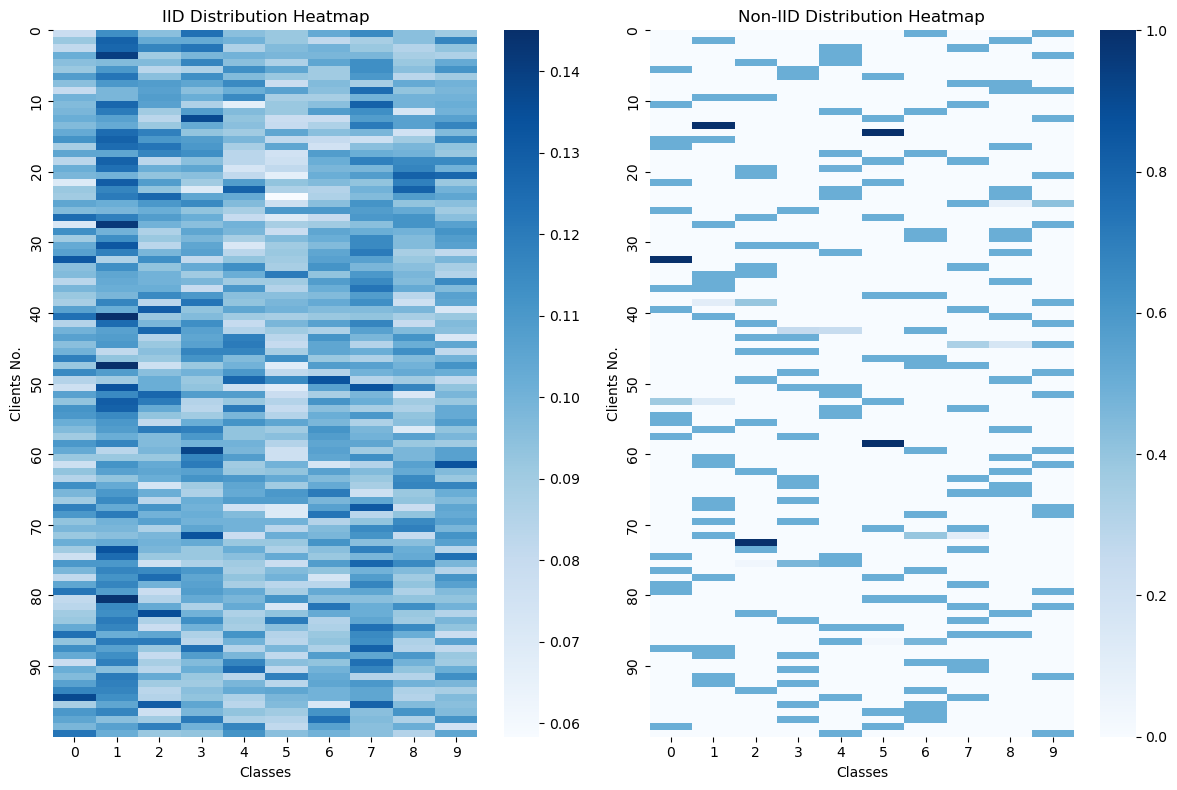

In [66]:
# Test iid and non-iid is correct.

# iid
iid_labels = []
for i in iid_train_loader:
    iid_label = torch.zeros(10)
    for (x,y) in i:
        iid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    iid_labels.append(iid_label)
    
iid_labels = torch.stack(iid_labels)
iid_normalized = iid_labels / 600 # min-max normalization

# non_iid
noniid_labels = []
for i in noniid_train_loader:
    noniid_label = torch.zeros(10)
    for (x,y) in i:
        noniid_label += torch.sum(F.one_hot(y, num_classes=10), dim=0)
    noniid_labels.append(noniid_label)
    
noniid_labels = torch.stack(noniid_labels)
noniid_normalized = noniid_labels / 600

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.heatmap(iid_normalized.numpy(), cmap='Blues', fmt=".2f", cbar=True, annot=False)
plt.yticks(np.arange(0, 100, step=10), [i * 10 for i in range(10)])
plt.xlabel('Classes')
plt.ylabel('Clients No.')
plt.title('IID Distribution Heatmap')

plt.subplot(1, 2, 2)
sns.heatmap(noniid_normalized.numpy(), cmap='Blues', fmt=".2f", cbar=True, annot=False)
plt.yticks(np.arange(0, 100, step=10), [i * 10 for i in range(10)])
plt.xlabel('Classes')
plt.ylabel('Clients No.')
plt.title('Non-IID Distribution Heatmap')

plt.tight_layout()
plt.show()

In [67]:
# Model Defination

# Model 1: A simple multilayer-perceptron with 2-hidden
# layers with 200 units each using ReLu activations (199,210
# total parameters), which we refer to as the MNIST 2NN.

# define fully connected NN
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(784, 200);
        self.fc2 = nn.Linear(200, 200);
        self.out = nn.Linear(200, 10);

    def forward(self, x):
        x = x.flatten(1) # torch.Size([B,784])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

print(MLP())
print("Total parameters of 2NN(MLP) is", num_params(MLP()))

MLP(
  (fc1): Linear(in_features=784, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (out): Linear(in_features=200, out_features=10, bias=True)
)
Total parameters of 2NN(MLP) is 199210


In [68]:
# Fed_Avg
def fedavg(global_model, C, K, E, c_loader, rounds, lr, acc_threshold):
    # C is the fraction of clients that perform computation on each round.
    assert C <= 1 and C >= 0
    # K is the number of clients.
    # E is the local epochs, the number of training passes each client makes
    # over its local dataset on each round.
    
    c_per_round = max( round(C * K), 1)
    accuracy = []
    entropys_of_rounds = []
    VR_of_rounds = []
    
    for rd in range(rounds):
        
        # Choose c_per_round clients
        clients = random.sample(range(K), c_per_round)
        
        # Train on clients one by one
        client_model = []
        entropys_of_clients = []
        VR_of_clients = []
        for i, c in enumerate(clients):
            local_model, entropy, VR = client_training(global_model, id = c, local_epochs = E, dataloader = c_loader[c], lr = lr)
            local_model = local_model.to(device)
            client_model.append(local_model.state_dict())
            entropys_of_clients.append(entropy)
            VR_of_clients.append(VR)
        
        entropys_of_rounds.append(entropys_of_clients)
        VR_of_rounds.append(VR_of_clients)
    
        # Average and iterate global model parameters for next round  
        keys = client_model[0].keys()
        next_global_dict = {key: 0 for key in keys}
        for key in keys:
            values = [d[key] for d in client_model]
            averaged_value = sum(values) / len(values)
            next_global_dict[key] = averaged_value
            
        global_model.load_state_dict(next_global_dict)
        global_model = global_model.to(device)
        
        # Validate accuracy this round

        global_model.eval()
        with torch.no_grad():
            predictions = global_model(test_inputs)

        predicted_labels = torch.argmax(predictions, dim=1).cpu().numpy()
        true_labels = test_labels.cpu().numpy()

        acc = accuracy_score(true_labels, predicted_labels)
        if rd%10 == 0 or acc >= acc_threshold:
            print("The clients in round {} are: {}".format(rd, clients))
            print("Accuracy of round {}:{}".format(rd, acc))
            print()
        accuracy.append(acc)
        if acc >= acc_threshold:
            break
        
    return accuracy, entropys_of_rounds, VR_of_rounds

Choose entropy and variation ratios for uncertainty estimation:
$$\mathbb{H}[y|\mathbf{x},\mathcal{D}_{test}]:=-\sum_{c}p(y=c|\mathbf{x},\mathcal{D}_{test})\log p(y=c|\mathbf{x},\mathcal{D}_{test})$$

$$\text{variation ratios}[\mathbf{x}] := 1 - max_{y}p(y|\mathbf{x},\mathcal{D}_{test})$$

In [69]:
# Calculate the averaged entropy of the local model after every local training
def calculate_entropy(output):
    # The differences between 2NN and CNN, 2NN doesn't have a softmax layer
    probabilities = F.softmax(output, dim=1)
    log_probabilities = torch.log(probabilities)
    entropy = -torch.sum(probabilities * log_probabilities, dim=1)
    return entropy.mean().item()

# Calculate Variation Ratio of the local model after every local training 
def calculate_VR(output):
    probabilities = F.softmax(output, dim=1)
    highest_prob, _ = torch.max(probabilities, dim=1)
    # print(highest_prob.shape)
    variation_ratio = 1 - highest_prob
    # print(variation_ratio.shape)
    # print(variation_ratio.mean().item())
    return variation_ratio.mean().item()

In [70]:
criterion = nn.CrossEntropyLoss()

def client_training(global_model, id, local_epochs, dataloader, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(device)
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
    
    for epoch in range(local_epochs):
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = local_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        # Calculate the Averaged Entropy After All Epoches:
    with torch.no_grad():
        test_outputs = local_model(test_inputs)
        entropy = calculate_entropy(test_outputs)
        VR = calculate_VR(test_outputs)
            
    return local_model, entropy, VR

# MNIST 2NN

In [71]:
mlp = MLP()
acc_threshold_2nn = 0.97

In [72]:
def pltUncertainty(A, B, title):
    max_entropy_values = [np.max(a_i) for a_i in A]
    min_entropy_values = [np.min(a_i) for a_i in A]
    avg_entropy_values = [np.mean(a_i) for a_i in A]

    max_vr_values = [np.max(b_i) for b_i in B]
    min_vr_values = [np.min(b_i) for b_i in B]
    avg_vr_values = [np.mean(b_i) for b_i in B]

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

    ax1.fill_between(np.log10(range(1, len(A) + 1)), min_entropy_values, max_entropy_values, facecolor='red', alpha=0.2)
    ax1.plot(np.log10(range(1, len(A) + 1)), avg_entropy_values, color='red')
    ax1.set_xlabel('Rounds')
    ax1.set_ylabel('Uncertainty (Entropy)')

    ax2.fill_between(np.log10(range(1, len(B) + 1)), min_vr_values, max_vr_values, facecolor='blue', alpha=0.2)
    ax2.plot(np.log10(range(1, len(B) + 1)), avg_vr_values, color='blue')
    ax2.set_xlabel('Rounds')
    ax2.set_ylabel('Uncertainty (Variation Ratio)')

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

In [73]:
def pltVarVSAcc(A, E, title):
    var_values = [statistics.variance(e_i) for e_i in E]

    fig, ax = plt.subplots()
    ax.plot(range(1, len(E) + 1), var_values, color='blue', label='Variance of uncertainty')
    ax.set_xlabel('Rounds')
    ax.set_ylabel('Variance of uncertainty')
    
    ax.yaxis.label.set_color('blue')
    ax.tick_params(axis='y', colors='blue')
    ax.spines['left'].set_color('blue')
    ax.spines['right'].set_color('red')

    ax2 = ax.twinx()
    ax2.plot(range(1, len(A) + 1), A, marker='.', linestyle='-', color='red', label='Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.yaxis.label.set_color('red')
    ax2.tick_params(axis='y', colors='red')
    ax2.spines['right'].set_color('red')
    ax2.spines['left'].set_color('blue')

    fig.suptitle(title)
    fig.legend(loc='center right')

    plt.show()

## 1. iid,  C = 0.1

In [32]:
# iid C = 0.1
mlp_iid1 = copy.deepcopy(mlp)
acc_mlp_iid1, entropy_2nn_iid1, VR_2nn_iid1 = fedavg(mlp_iid1, C = 0.1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

The clients in round 0 are: [15, 77, 83, 25, 38, 35, 88, 23, 12, 60]
Accuracy of round 0:0.5991

The clients in round 10 are: [89, 63, 54, 4, 38, 42, 94, 87, 19, 21]
Accuracy of round 10:0.9056

The clients in round 20 are: [19, 48, 74, 37, 91, 90, 60, 8, 10, 66]
Accuracy of round 20:0.9261

The clients in round 30 are: [79, 16, 80, 41, 13, 89, 70, 83, 44, 24]
Accuracy of round 30:0.9415

The clients in round 40 are: [0, 37, 47, 88, 3, 77, 29, 18, 23, 58]
Accuracy of round 40:0.9482

The clients in round 50 are: [22, 31, 58, 43, 66, 18, 45, 59, 80, 81]
Accuracy of round 50:0.9561

The clients in round 60 are: [20, 15, 89, 48, 51, 75, 59, 17, 71, 85]
Accuracy of round 60:0.9607

The clients in round 70 are: [7, 95, 81, 86, 22, 29, 78, 38, 11, 90]
Accuracy of round 70:0.9643

The clients in round 80 are: [10, 30, 12, 97, 19, 52, 27, 56, 78, 9]
Accuracy of round 80:0.9656

The clients in round 90 are: [19, 22, 65, 9, 17, 97, 26, 99, 63, 72]
Accuracy of round 90:0.9687

The clients in roun

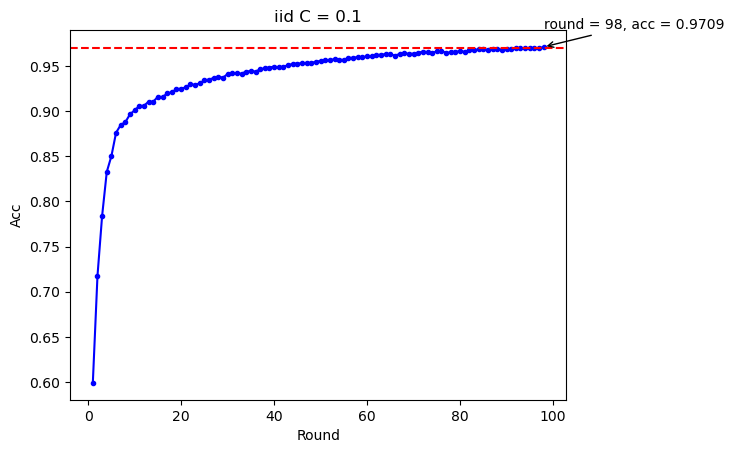

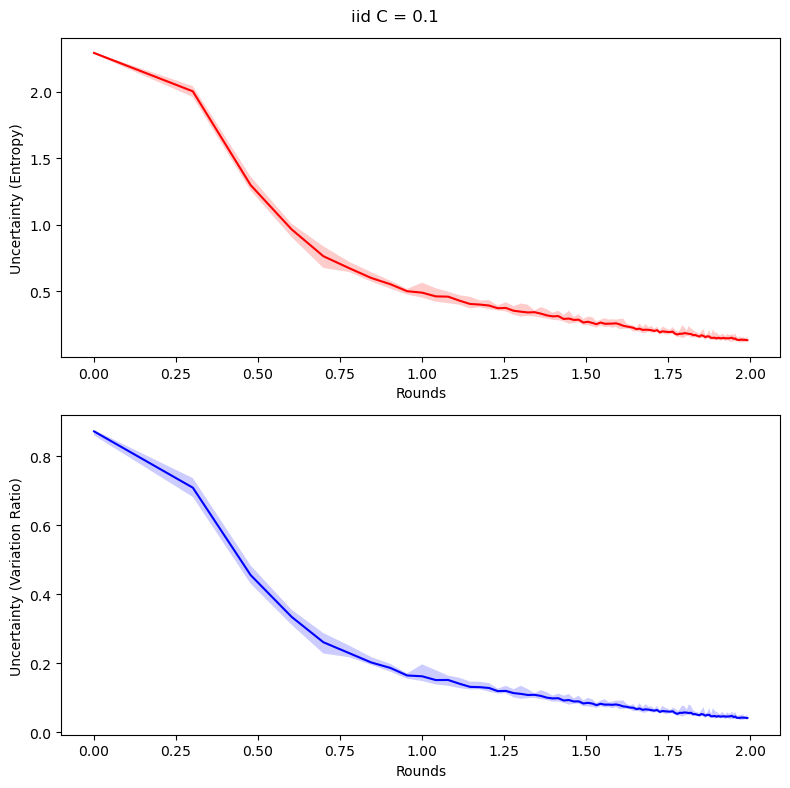

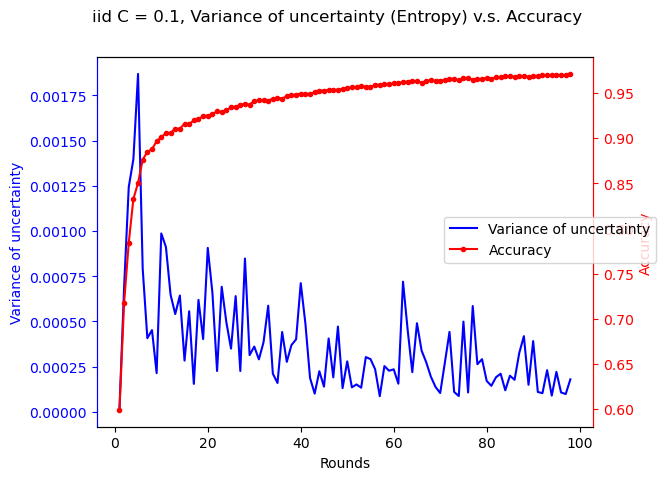

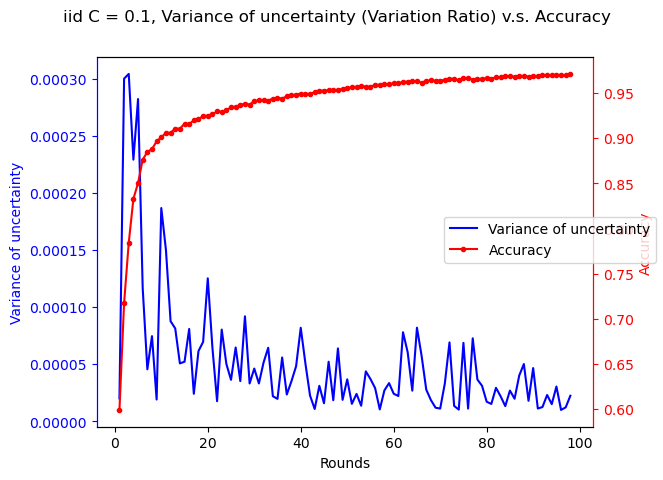

98 rounds needed to achieve the accuracy of 0.9709


In [59]:
pltAcc(acc_mlp_iid1, acc_threshold_2nn, 'iid C = 0.1')
pltUncertainty(entropy_2nn_iid1, VR_2nn_iid1, 'iid C = 0.1')
pltVarVSAcc(acc_mlp_iid1, entropy_2nn_iid1, 'iid C = 0.1, Variance of uncertainty (Entropy) v.s. Accuracy')
pltVarVSAcc(acc_mlp_iid1, VR_2nn_iid1, 'iid C = 0.1, Variance of uncertainty (Variation Ratio) v.s. Accuracy')

print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid1), acc_mlp_iid1[-1]))

## 2. iid, C = 0.2

In [ ]:
# iid C = 0.2
mlp_iid2 = copy.deepcopy(mlp)
acc_mlp_iid2, entropy_2nn_iid2  = fedavg(mlp_iid2, C = 0.2, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_iid2, acc_threshold_2nn, 'iid C = 0.2')
pltUncertainty(entropy_2nn_iid2, 'iid C = 0.2')
pltVar(entropy_2nn_iid2, 'iid C = 0.2')

print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid2), acc_mlp_iid2[-1]))

## 3. iid, C = 0.5

In [ ]:
# iid C = 0.5
mlp_iid3 = copy.deepcopy(mlp)
acc_mlp_iid3, entropy_2nn_iid3 = fedavg(mlp_iid3, C = 0.5, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_iid3, acc_threshold_2nn, 'iid C = 0.5')
pltUncertainty(entropy_2nn_iid3, 'iid C = 0.5')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid3), acc_mlp_iid3[-1]))

## 4. iid, C = 1

In [ ]:
# iid C = 1
mlp_iid4 = copy.deepcopy(mlp)
acc_mlp_iid4, entropy_2nn_iid4 = fedavg(mlp_iid4, C = 1, K = 100, E = 1, 
                      c_loader = iid_train_loader, rounds = 100, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_iid4, acc_threshold_2nn, 'iid C = 1')
pltUncertainty(entropy_2nn_iid4, 'iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_iid4), acc_mlp_iid4[-1]))

## 5. non-iid, C = 0.1

In [ ]:
# non-iid C = 0.1
mlp_noniid1 = copy.deepcopy(mlp)
acc_mlp_noniid1, entropy_2nn_noniid1 = fedavg(mlp_noniid1, C = 0.1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid1, acc_threshold_2nn, 'non-iid C = 0.1')
pltUncertainty(entropy_2nn_noniid1, 'non-iid C = 0.1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid1), acc_mlp_noniid1[-1]))

## 6. non-iid, C = 0.2

In [ ]:
# non-iid C = 0.2
mlp_noniid2 = copy.deepcopy(mlp)
acc_mlp_noniid2, entropy_2nn_noniid2 = fedavg(mlp_noniid2, C = 0.2, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid2, acc_threshold_2nn, 'non-iid C = 0.2')
pltUncertainty(entropy_2nn_noniid2, 'non-iid C = 0.2')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid2), acc_mlp_noniid2[-1]))

## 7. non-iid, C = 0.5

In [60]:
# non-iid C = 0.5
mlp_noniid3 = copy.deepcopy(mlp)
acc_mlp_noniid3, entropy_2nn_noniid3, VR_2nn_noniid3 = fedavg(mlp_noniid3, C = 0.5, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

The clients in round 0 are: [19, 45, 2, 62, 80, 7, 3, 30, 5, 1, 28, 83, 41, 8, 94, 44, 54, 17, 27, 57, 55, 18, 98, 39, 22, 42, 52, 48, 90, 73, 33, 68, 59, 91, 15, 70, 49, 10, 0, 32, 86, 76, 79, 74, 60, 53, 46, 84, 9, 66]
Accuracy of round 0:0.3481

The clients in round 10 are: [49, 91, 22, 19, 2, 3, 41, 65, 0, 4, 6, 14, 73, 78, 18, 96, 48, 94, 53, 55, 72, 42, 31, 17, 46, 92, 27, 68, 51, 9, 16, 52, 44, 12, 80, 74, 77, 30, 24, 88, 58, 25, 15, 93, 62, 59, 37, 90, 69, 76]
Accuracy of round 10:0.7926

The clients in round 20 are: [87, 11, 24, 38, 66, 80, 86, 15, 7, 19, 43, 4, 42, 79, 20, 59, 49, 97, 52, 63, 82, 21, 50, 6, 89, 95, 93, 41, 23, 74, 69, 55, 90, 94, 27, 56, 88, 92, 31, 57, 96, 53, 85, 35, 46, 12, 0, 2, 3, 8]
Accuracy of round 20:0.8615

The clients in round 30 are: [46, 45, 11, 74, 55, 14, 89, 3, 22, 1, 76, 68, 34, 98, 26, 49, 25, 40, 23, 91, 63, 19, 75, 64, 52, 29, 0, 6, 95, 4, 17, 93, 10, 53, 39, 42, 24, 86, 92, 21, 8, 20, 88, 47, 69, 31, 30, 38, 60, 71]
Accuracy of round 30:0

The clients in round 330 are: [35, 67, 3, 85, 17, 2, 23, 9, 77, 7, 30, 45, 58, 52, 62, 99, 93, 39, 60, 56, 63, 78, 24, 82, 71, 66, 72, 69, 20, 26, 22, 84, 15, 55, 88, 81, 74, 48, 37, 96, 43, 36, 68, 6, 70, 95, 76, 11, 25, 97]
Accuracy of round 330:0.9658

The clients in round 340 are: [88, 21, 65, 75, 70, 9, 99, 31, 19, 23, 37, 69, 44, 80, 77, 96, 25, 3, 40, 55, 35, 89, 63, 58, 57, 49, 8, 10, 17, 95, 14, 30, 6, 93, 11, 53, 47, 67, 86, 22, 68, 38, 24, 42, 59, 13, 87, 33, 2, 45]
Accuracy of round 340:0.9671

The clients in round 350 are: [60, 92, 36, 6, 14, 63, 73, 5, 21, 15, 67, 89, 58, 39, 98, 84, 48, 44, 82, 83, 35, 80, 59, 31, 99, 76, 97, 68, 52, 78, 91, 90, 11, 1, 96, 64, 26, 86, 34, 19, 7, 37, 54, 72, 81, 87, 88, 25, 4, 42]
Accuracy of round 350:0.9657

The clients in round 360 are: [22, 63, 20, 47, 67, 31, 45, 19, 88, 91, 78, 83, 11, 46, 73, 72, 42, 17, 66, 32, 26, 43, 49, 24, 87, 53, 93, 1, 23, 74, 71, 7, 79, 4, 94, 56, 99, 3, 58, 37, 33, 98, 69, 2, 34, 60, 8, 96, 80, 82]
Accurac

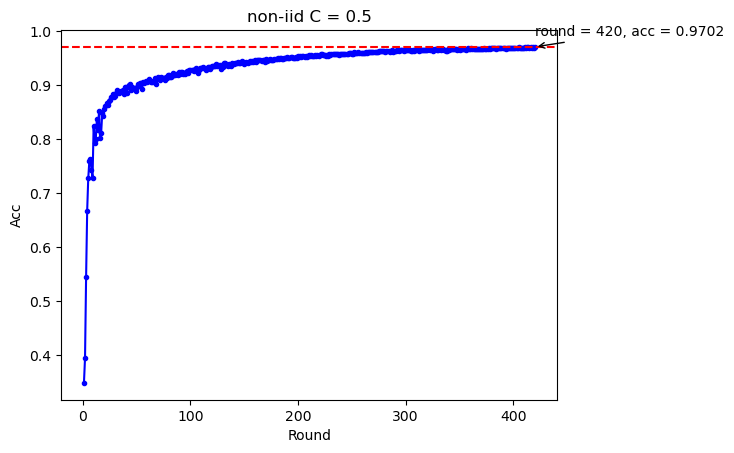

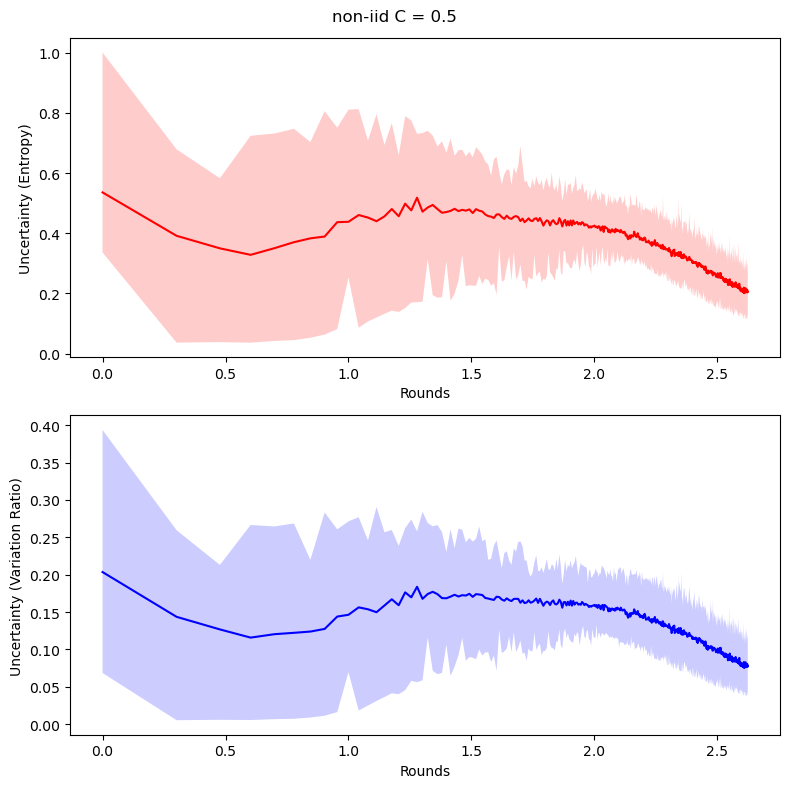

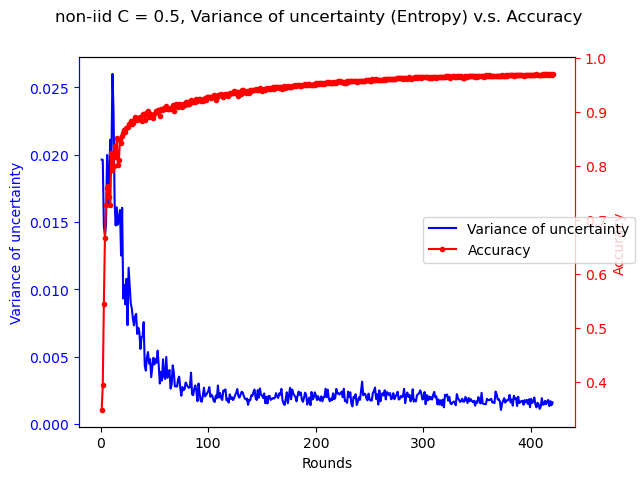

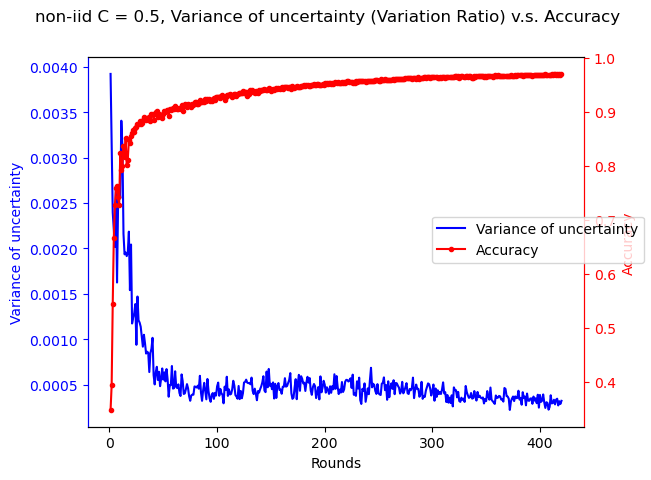

420 rounds needed to achieve the accuracy of 0.9702


In [61]:
pltAcc(acc_mlp_noniid3, acc_threshold_2nn, 'non-iid C = 0.5')
pltUncertainty(entropy_2nn_noniid3, VR_2nn_noniid3, 'non-iid C = 0.5')
pltVarVSAcc(acc_mlp_noniid3, entropy_2nn_noniid3, 'non-iid C = 0.5, Variance of uncertainty (Entropy) v.s. Accuracy')
pltVarVSAcc(acc_mlp_noniid3, VR_2nn_noniid3, 'non-iid C = 0.5, Variance of uncertainty (Variation Ratio) v.s. Accuracy')

print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid3), acc_mlp_noniid3[-1]))

## 8. non-iid, C = 1

In [ ]:
# non-iid C = 1
mlp_noniid4 = copy.deepcopy(mlp)
acc_mlp_noniid4, entropy_2nn_noniid4 = fedavg(mlp_noniid4, C = 1, K = 100, E = 1, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

In [ ]:
pltAcc(acc_mlp_noniid4, acc_threshold_2nn, 'non-iid C = 1')
pltUncertainty(entropy_2nn_noniid4, 'non-iid C = 1')
print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid4), acc_mlp_noniid4[-1]))

## 9. non-iid, C = 0.5, E = 20

In [74]:
# non-iid C = 0.5 E = 20
mlp_noniid5 = copy.deepcopy(mlp)
acc_mlp_noniid5, entropy_2nn_noniid5, VR_2nn_noniid5 = fedavg(mlp_noniid5, C = 0.5, K = 100, E = 20, 
                      c_loader = noniid_train_loader, rounds = 500, 
                      lr = 0.05, acc_threshold = acc_threshold_2nn)

The clients in round 0 are: [98, 7, 86, 20, 96, 43, 67, 32, 15, 76, 56, 85, 22, 1, 60, 52, 72, 65, 39, 45, 49, 92, 19, 71, 97, 58, 10, 42, 5, 69, 35, 17, 30, 61, 80, 36, 82, 37, 88, 57, 40, 54, 81, 8, 63, 77, 24, 47, 26, 41]
Accuracy of round 0:0.319

The clients in round 10 are: [61, 44, 90, 33, 16, 3, 26, 46, 42, 60, 37, 89, 70, 81, 41, 23, 75, 10, 13, 68, 74, 39, 20, 48, 18, 95, 28, 40, 65, 31, 30, 84, 88, 47, 53, 5, 79, 38, 1, 25, 4, 98, 59, 8, 93, 19, 35, 55, 66, 9]
Accuracy of round 10:0.8667

The clients in round 20 are: [92, 84, 98, 28, 33, 44, 85, 20, 39, 2, 45, 73, 69, 7, 80, 19, 89, 90, 62, 93, 86, 3, 30, 5, 1, 96, 41, 8, 79, 94, 54, 17, 27, 57, 55, 18, 83, 97, 11, 88, 21, 46, 50, 47, 26, 24, 0, 65, 16, 34]
Accuracy of round 20:0.9032

The clients in round 30 are: [20, 74, 0, 87, 49, 91, 22, 19, 2, 3, 41, 65, 97, 4, 6, 14, 73, 78, 18, 92, 48, 90, 53, 55, 72, 42, 31, 17, 46, 88, 27, 68, 51, 9, 16, 52, 44, 61, 85, 69, 57, 60, 15, 30, 24, 84, 25, 59, 89, 56]
Accuracy of round 3

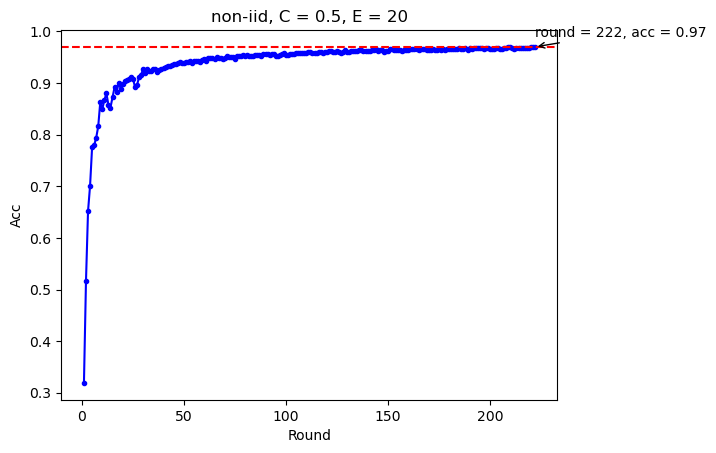

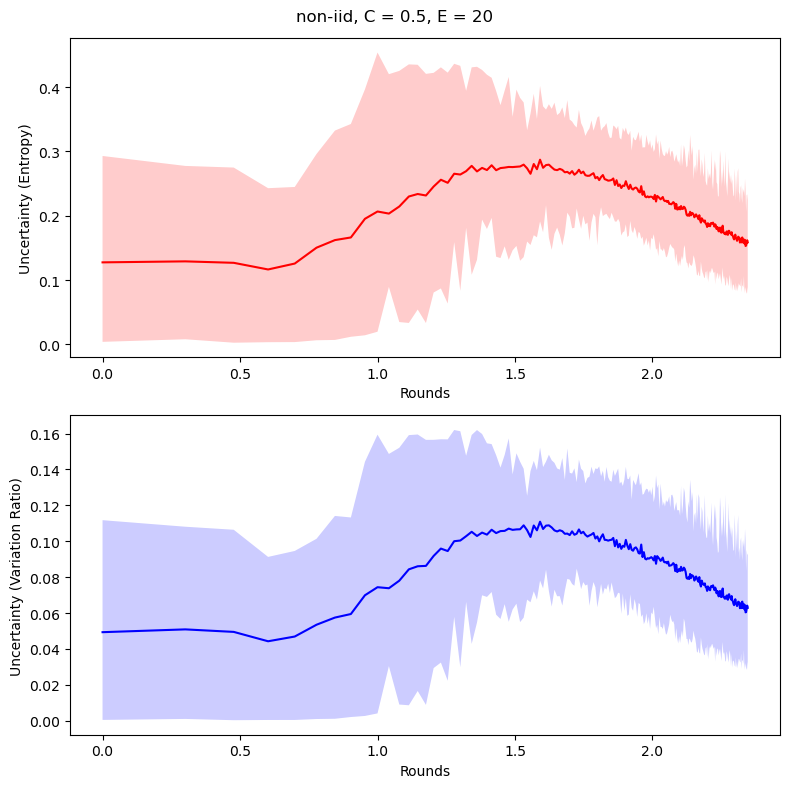

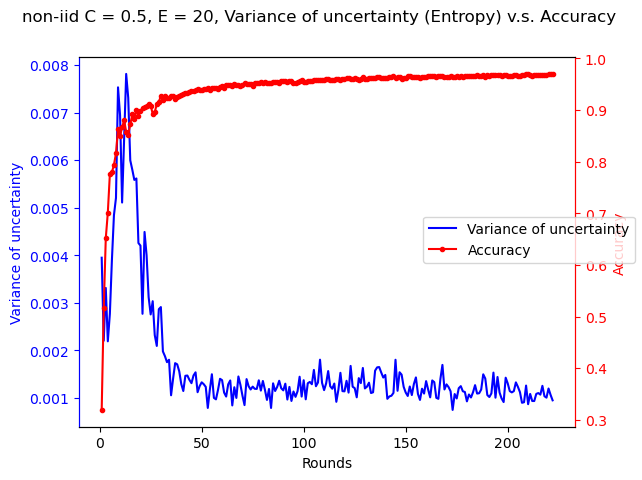

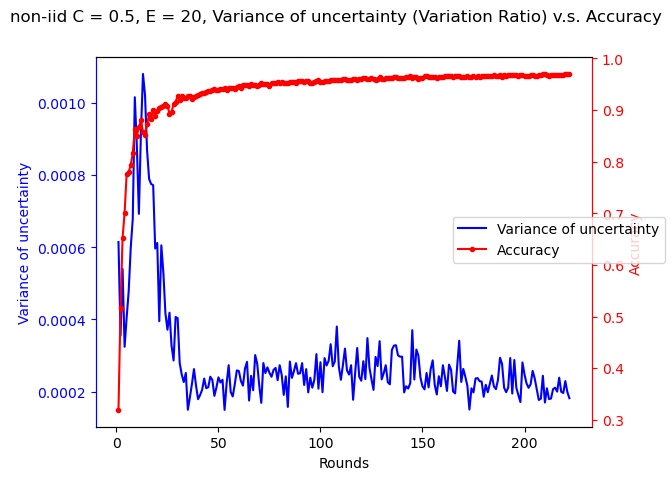

222 rounds needed to achieve the accuracy of 0.97


In [75]:
pltAcc(acc_mlp_noniid5, acc_threshold_2nn, 'non-iid, C = 0.5, E = 20')
pltUncertainty(entropy_2nn_noniid5, VR_2nn_noniid5, 'non-iid, C = 0.5, E = 20')
pltVarVSAcc(acc_mlp_noniid5, entropy_2nn_noniid5, 'non-iid C = 0.5, E = 20, Variance of uncertainty (Entropy) v.s. Accuracy')
pltVarVSAcc(acc_mlp_noniid5, VR_2nn_noniid5, 'non-iid C = 0.5, E = 20, Variance of uncertainty (Variation Ratio) v.s. Accuracy')

print("{} rounds needed to achieve the accuracy of {}".format(len(acc_mlp_noniid5), acc_mlp_noniid5[-1]))

## Comparison among 8 groups

In [ ]:
plt.figure(figsize=(12, 8))
log_rounds = np.log10(range(50, 500, 100))
rounds = range(50, 500, 100) 

plt.plot(np.log10(range(1, len(acc_mlp_iid1) + 1)), acc_mlp_iid1, marker='.', linestyle='solid', color='blue', label='iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_iid2) + 1)), acc_mlp_iid2, marker='.', linestyle='solid', color='green', label='iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_iid3) + 1)), acc_mlp_iid3, marker='.', linestyle='solid', color='red', label='iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_iid4) + 1)), acc_mlp_iid4, marker='.', linestyle='solid', color='purple', label='iid, C = 1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid1) + 1)), acc_mlp_noniid1, marker='.', linestyle='dotted', color='orange', label='non-iid, C = 0.1')
plt.plot(np.log10(range(1, len(acc_mlp_noniid2) + 1)), acc_mlp_noniid2, marker='.', linestyle='dotted', color='cyan', label='non-iid, C = 0.2')
plt.plot(np.log10(range(1, len(acc_mlp_noniid3) + 1)), acc_mlp_noniid3, marker='.', linestyle='dotted', color='magenta', label='non-iid, C = 0.5')
plt.plot(np.log10(range(1, len(acc_mlp_noniid4) + 1)), acc_mlp_noniid4, marker='.', linestyle='dotted', color='brown', label='non-iid, C = 1')

plt.axhline(y=acc_threshold_2nn, color='gray', linestyle='solid')

plt.xlabel('Rounds')
plt.ylabel('Acc')

plt.title('Test set accuracy vs. communication rounds for MNIST 2NN')

plt.ylim(0.8, 1)
plt.xticks(log_rounds, rounds)

plt.legend()

plt.show()